# <center>**Otimização de hiperparâmetros e Redução de dimensionalidade**

### <center> - *Otimização de hiperparâmetros pelo Optuna e Seleção de atributos (RFE e VFI)* - <center>

> A prática leva a perfeição.

<p style="text-align:justify;"><div class="alert alert-danger">Considerando o tamanho dos arquivos utilizados, recomenda-se rodar o código utilizando HPC.</p>


### 📚 **Importação de Bibliotecas**

In [1]:
# Bibliotecas Gerais
import os
import pandas as pd
import numpy as np
import seaborn as sns

# Bibliotecas para gráficos
from matplotlib import pyplot as plt

# Bibliotecas do scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Importação do optuna
import optuna
from optuna import create_study

### 📂 **Importação dos dataframes e definição dos valores de treino e teste**

Antes de começar os processos, é preciso definir os valorer de treino e teste, através da importação dos dataframes definidos na introdução.

In [5]:
# Para rodar no HPC

df_condutividade = pd.read_csv("../data/dataset_condutividade.csv", sep=',')

df1 = pd.read_csv("data/df_treino_target.csv", sep=',')
y_treino = df1["critical_temp"].values.ravel()

df2 = pd.read_csv("data/df_teste_target.csv", sep=',')
y_teste = df2["critical_temp"].values.ravel()

df3 = pd.read_csv("data/df_treino_features.csv", sep=',')
X_treino = df3.values  

df4 = pd.read_csv("data/df_teste_features.csv", sep=',')
X_teste = df4.values

### ✔️**Seleção de atributos**

<div style="text-align:justify;">
No notebook "Modelos 4" contido na pasta de "Quests 3" [1], alguns testes foram realizados para tentar reduzir a dimensionalidade dos dados contidos no dataset em análise. Três técnicas foram aplicadas:
    
* Análise de Componente Principal (PCA): Utiliza a matriz de covariância dos dados, para calcular os autovalores dessa matriz (por meio do método SVD) e, com isso, projetar os dados em um novo sistema de coordenadas, maximizando a variância nos primeiros componentes principais (PCs).
  
* Fator de Inflação de Variância (VIF): Consiste na eliminação de colunas com multicolinearidade (isto é, no qual uma feature pode ser prevista a partir de uma combinação linear de outras features).
  
* Remoção Recursiva de Atributos (RFE): Busca reduzir a quantidade de features para um número específico, eliminando recursivamente as menos relevantes com base no peso do atributo em questão para o modelo (Vale ressaltar que esse método só pode ser aplicado em modelos que apresentam pesos para as features, como a árvore de decisão ou floresta aleatória).

A utilização dos atributos obtidos pelas três técnicas, como evidencia-se nos resultados das hipóteses da referência 1, proporcionaram resultados <strong> piores </strong> do que aqueles obtidos com o uso de todas as features. Esse resultado sugere que a maioria dos atributos contribui significativamente para a predição do target, de modo que a remoção de alguns pode prejudicar o modelo. Provavelmente, os atributos possuem relevâncias distribuídas uniformemente, de modo que cada feature adiciona uma pequena, mas importante, porção de informação. Nesse caso, a redução de dimensionalidade pode resultar em perda de detalhes, afetando negativamente a predição.

Além disso, o baixo desempenho do PCA e VIF pode também estar relacionado à baixa correlação entre as variáveis do dataset. Como é possível notar na matriz de correlação [Gráfico 1], as áreas de maior correlação (representadas pelo vermelho com tom mais escuro) estão majoritariamente na diagonal principal - resultado já esperado, visto que essa representa a correlação entre duas colunas iguais - o que indica que os demais atributos não possuem grande correlação.  Ambas as técnicas se beneficiam de alta correlação para identificar redundâncias e, em sua ausência, perdem eficácia.
</div>

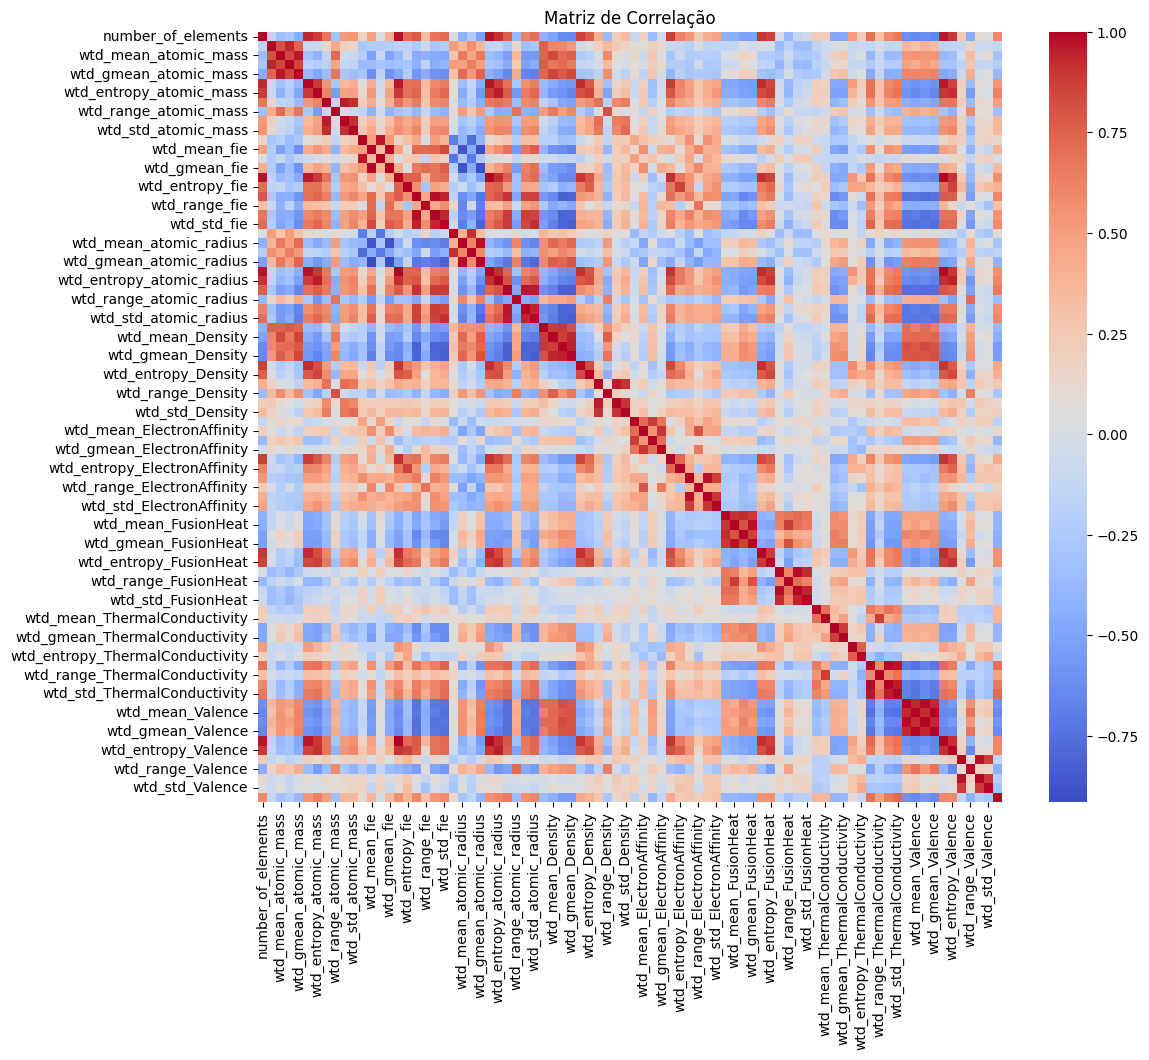

In [13]:
matriz_covariancia = df_condutividade.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(matriz_covariancia, annot=False, fmt=".2f", cmap='coolwarm')
plt.title('Matriz de Correlação');
plt.show()

<center> [Gráfico 1: Matriz de Correlação do Dataset utilizado]

### **🐙Otimização por optuna**

<div style="text-align:justify;">
A biblioteca ``Optuna`` permite a otimização de hiperparâmetros, os quais consistem em configurações externas a um modelo de aprendizado de máquina que definem o processo de aprendizagem. Ela facilita a busca por valores ideais para os hiperparâmetros associados ao modelo preditivo escolhido, visando potencializar a eficácia do modelo.

Neste contexto, será realizada uma busca pelos hiperparâmetros dos modelos k-NN, árvore de decisão e floresta aleatória. É importante destacar que regressores lineares, como o SGD e o regressor linear múltiplo, não possuem hiperparâmetros e, portanto, não serão incluídos nesse processo.

Os códigos utilizados são baseados na referência 2. Para armazenar os resultados das melhores tentativas de cada modelo, dataframes serão criados, os quais serão utilizados posteriormente nos notebooks relacionados ao desenvolvimento.

Ademais, para cada modelo, os hiperparâmetros utilizados para otimização serão explicados. No entanto, para melhor entendimento do funcionamento completo, recomenda-se leitura do demais notebooks presentes no desenvolvimento.
</div>

*Vale lembrar que antes das otimizações é preciso definir a semente aleatória que será utilizada, a qual será mesma do split feito na introdução.

In [4]:
semente_aleatoria = 101820

#### 🏠🏡**k-NN**

**Hiperparâmetros utilizados**

O K-Nearest Neighbors (k-NN) é um algoritmo que classifica novos dados com base nos k dados já rotulados mais próximos. Nesse sentido, os hiperparâmetros que podem ser utilizados são:

* ``n_neighbors``: Define o número de vizinhos mais próximos a serem considerados ao fazer uma previsão. Este hiperparâmetro é crucial para equilibrar o viés e a variância do modelo: um pequeno número de vizinhos pode gerar alta variância (overfitting), pois o modelo se ajusta demais aos dados de treinamento. Em contraste, um grande número de vizinhos tende a aumentar o viés (underfitting), dificultando a captura de padrões nos dados.
* ``weights``: Este parâmetro determina como o peso de cada vizinho é calculado. Com a opção "uniforme", todos os vizinhos têm o mesmo peso na decisão. Por outro lado, ao utilizar "distância", os vizinhos mais próximos têm maior influência, pois seu peso é inversamente proporcional à sua distância do ponto em análise.

**Otimização dos hiperparâmetros**

In [16]:
run_this_cell_optuna_knn = True
if run_this_cell_optuna_knn:

    def cria_instancia_modelo_knn(trial):
        """Cria uma instância do modelo desejado (kNN)"""
        
        parametros = {
            "n_neighbors": trial.suggest_int("n_neighbors", 1, 50), 
            "weights": trial.suggest_categorical("weights", ["uniform", "distance"]), 
        }
        
        modelo = KNeighborsRegressor(**parametros)

        return modelo

    def funcao_objetivo(trial, X, y, num_folds):
        """Computa o RMSE - com a utilização de validação cruzada - para teste a eficiência das instâncias geradas """

        modelo = cria_instancia_modelo_knn(trial) 

        metricas = cross_val_score(
            modelo,
            X,
            y,
            scoring="neg_root_mean_squared_error",
            cv=num_folds,
        )
        return -metricas.mean()

    def funcao_objetivo_parcial(trial):
        "Função objetivo que apenas possui como argumento o objeto trial"
        return funcao_objetivo(trial, X_treino, y_treino, 10)

    estudo_knn = create_study(
        direction="minimize",
        study_name="k_nn_dataset_condutores_optuna",
        storage=f"sqlite:///k_nn_dataset_condutores_optuna.db",
        load_if_exists=True,
    )

    estudo_knn.optimize(funcao_objetivo_parcial, n_trials=100)

    melhor_trial_knn = estudo_knn.best_trial

    parametros_melhor_trial_knn = melhor_trial_knn.params
    print(f"Parâmetros do melhor trial: {parametros_melhor_trial_knn}")

[I 2024-10-25 09:17:27,629] A new study created in RDB with name: k_nn_dataset_condutores_optuna
[I 2024-10-25 09:17:28,476] Trial 0 finished with value: 17.79913963865453 and parameters: {'n_neighbors': 29, 'weights': 'uniform'}. Best is trial 0 with value: 17.79913963865453.
[I 2024-10-25 09:17:29,272] Trial 1 finished with value: 16.74973395490058 and parameters: {'n_neighbors': 18, 'weights': 'uniform'}. Best is trial 1 with value: 16.74973395490058.
[I 2024-10-25 09:17:30,308] Trial 2 finished with value: 13.800909986979908 and parameters: {'n_neighbors': 29, 'weights': 'distance'}. Best is trial 2 with value: 13.800909986979908.
[I 2024-10-25 09:17:31,161] Trial 3 finished with value: 18.35777744156799 and parameters: {'n_neighbors': 37, 'weights': 'uniform'}. Best is trial 2 with value: 13.800909986979908.
[I 2024-10-25 09:17:31,867] Trial 4 finished with value: 13.385507914450335 and parameters: {'n_neighbors': 21, 'weights': 'distance'}. Best is trial 4 with value: 13.38550791

Parâmetros do melhor trial: {'n_neighbors': 4, 'weights': 'distance'}


**Resultados do estudo**

In [17]:
parametros_melhor_trial_knn

{'n_neighbors': 4, 'weights': 'distance'}

In [11]:
otimizacao_knn = {'n_neighbors': 4, 'weights': 'distance'}
df_otimizacao_knn = pd.DataFrame.from_dict([otimizacao_knn])
df_otimizacao_knn.to_csv("data/df_otimizacao_knn.csv")

#### 🌲 **Árvore de Decisão**

**Hiperparâmetros utilizados**

Uma árvore de decisão é um modelo que apresenta a forma de um grafo direcional acíclico. O vértice raiz é o ponto inicial, e cada vértice de decisão divide os dados com base em uma característica específica, orientando o caminho que o dado deve seguir. As divisões continuam até alcançar os vértices folha, onde estão as previsões finais ou classes. A partir disso, é possível dizer que esse modelo apresenta os seguintes hiperparâmetros:

* ``min_samples_split``: Número mínimo de amostras para que um vértice seja um vértice condicional (ou seja, que um nó de pergunta seja dividido em dois). Um valor maior ajuda a evitar o overfitting, garantindo que cada divisão se baseie em um conjunto de dados representativo.
* ``min_samples_leaf``: Número mínimo de amostras por vértice folha. Esse parâmetro garante a estabilidade do modelo, ao garantir que a árvore crie vértices folha com poucas amostras, por exemplo.
* ``max_depth``: Profundidade máxima da árvore (ou seja, a quantidade de vértices que serão percorridos para chegar ao vértice raiz), o qual ajuda a controlar a complexidade do modelo. 

**Otimização dos hiperparâmetros**

In [20]:
run_this_cell_optuna_arvore = True
if run_this_cell_optuna_arvore:
    
    def cria_instancia_modelo_arvore(trial):
        """Cria uma instância do modelo desejado (Árvore de Decisão)"""
        
        parametros = {
            "min_samples_split": trial.suggest_int("min_exemplos_split", 5, 50), 
            "min_samples_leaf": trial.suggest_int("min_exemplos_folha", 1, 10), 
            "max_depth": trial.suggest_int("max_depth", 1, 30),   
            "random_state": semente_aleatoria
        }
        
        modelo = DecisionTreeRegressor(**parametros)
        return modelo
        
    def funcao_objetivo_arvore(trial, X, y, num_folds):
        """Computa o RMSE - com a utilização de validação cruzada - para teste a eficiência das instâncias geradas """

        modelo = cria_instancia_modelo_arvore(trial) 

        metricas = cross_val_score(
            modelo,
            X,
            y,
            scoring="neg_root_mean_squared_error",
            cv=num_folds,
        )
        return -metricas.mean()
        
    def funcao_objetivo_parcial_arvore(trial):
        "Função objetivo que apenas possui como argumento o objeto trial"
        return funcao_objetivo_arvore(trial, X_treino, y_treino, 10)

    estudo_arvore = create_study(
        direction="minimize",
        study_name="arvore_dataset_condutividade_optuna",
        storage=f"sqlite:///arvore_dataset_condutividade_optuna.db",
        load_if_exists=True,
    )

    estudo_arvore.optimize(funcao_objetivo_parcial_arvore, n_trials=100)

    melhor_trial_arvore = estudo_arvore.best_trial

    parametros_melhor_trial_arvore = melhor_trial_arvore.params

[I 2024-10-25 09:26:49,644] A new study created in RDB with name: arvore_dataset_condutividade_optuna
[I 2024-10-25 09:26:59,352] Trial 0 finished with value: 11.817970467197856 and parameters: {'min_exemplos_split': 13, 'min_exemplos_folha': 4, 'max_depth': 18}. Best is trial 0 with value: 11.817970467197856.
[I 2024-10-25 09:27:08,629] Trial 1 finished with value: 11.732414401510596 and parameters: {'min_exemplos_split': 8, 'min_exemplos_folha': 9, 'max_depth': 30}. Best is trial 1 with value: 11.732414401510596.
[I 2024-10-25 09:27:17,783] Trial 2 finished with value: 12.119560456500274 and parameters: {'min_exemplos_split': 13, 'min_exemplos_folha': 6, 'max_depth': 12}. Best is trial 1 with value: 11.732414401510596.
[I 2024-10-25 09:27:21,738] Trial 3 finished with value: 18.744445713450254 and parameters: {'min_exemplos_split': 47, 'min_exemplos_folha': 10, 'max_depth': 3}. Best is trial 1 with value: 11.732414401510596.
[I 2024-10-25 09:27:30,804] Trial 4 finished with value: 12

**Resultados do estudo**

In [25]:
parametros_melhor_trial_arvore

{'min_exemplos_split': 6, 'min_exemplos_folha': 10, 'max_depth': 24}

In [26]:
otimizacao_arvore = {'min_exemplos_split': 7, 'min_exemplos_folha': 10, 'max_depth': 24}
df_otimizacao_arvore = pd.DataFrame.from_dict([otimizacao_arvore])
df_otimizacao_arvore.to_csv("df_otimizacao_arvore.csv")

#### 🌲🌳🌲 **Floresta aleatória**

**Hiperparâmetros utilizados**

A floresta aleatória, de forma simples, consiste em um conjunto de árvores de decisão, onde cada árvore fornece uma "votação" ou predição, e o resultado final é obtido pela média (modelo regressor) ou pela votação majoritária (modelo classificatório) dessas predições. Dessa forma, além dos parâmetros básicos das árvores, os hiperparâmetros adicionais para floresta aleatória incluem:

* ``n_estimators``: Número de árvores utilizado para compor a floresta. Um número maior de árvores geralmente melhora a precisão, mas aumenta o tempo de processamento.
* ``bootstrap``: Determina se cada árvore usará uma amostra com reposição dos dados, ou seja, p modelo treina em várias subamostras retiradas aleatoriamente (com reposição) do conjunto de dados original. Esse processo cria múltiplas "versões" dos dados para cada árvore na floresta aleatória, aumentando a diversidade das árvores e ajudando a reduzir o overfitting. 

**Otimização dos hiperparâmtros**

In [5]:
def cria_instancia_modelo_floresta(trial):
    """Cria uma instância do modelo desejado (Floresta Aleatória)"""
    
    parametros = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 100, log=True),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_depth": trial.suggest_int("max_depth", 1, 30),
        "bootstrap": True, 
        "n_jobs": -1,
        "random_state": semente_aleatoria,\

    }
    
    modelo = RandomForestRegressor(**parametros)
    return modelo


def funcao_objetivo_floresta(trial, X, y, num_folds):
    """Calcula o RMSE com validação cruzada para avaliar as instâncias do modelo"""
    
    modelo = cria_instancia_modelo_floresta(trial)
    
    metricas = cross_val_score(
        modelo,
        X,
        y,
        scoring="neg_root_mean_squared_error",
        cv=num_folds,
    )
    
    return -metricas.mean()


def funcao_objetivo_parcial_floresta(trial):
    """Função objetivo que chama a função de validação cruzada com os dados de treino"""
    
    return funcao_objetivo_floresta(trial, X_treino, y_treino, 10)


estudo_floresta = optuna.create_study(
    direction="minimize",
    study_name="floresta_dataset_condutividade_optuna",
    storage=f"sqlite:///floresta_dataset_condutividade_optuna.db",
    load_if_exists=True,
)

estudo_floresta.optimize(funcao_objetivo_parcial_floresta, n_trials=100)

melhor_trial_floresta = estudo_floresta.best_trial
parametros_melhor_trial_floresta = melhor_trial_floresta.params


[I 2024-10-26 10:33:27,807] Using an existing study with name 'floresta_dataset_condutividade_optuna' instead of creating a new one.
[I 2024-10-26 10:34:38,830] Trial 96 finished with value: 9.396363367262598 and parameters: {'n_estimators': 87, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 22}. Best is trial 86 with value: 9.39241547262082.
[I 2024-10-26 10:35:41,560] Trial 97 finished with value: 9.435272150623053 and parameters: {'n_estimators': 86, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 22}. Best is trial 86 with value: 9.39241547262082.
[I 2024-10-26 10:36:30,170] Trial 98 finished with value: 10.37100861242475 and parameters: {'n_estimators': 79, 'min_samples_split': 3, 'min_samples_leaf': 12, 'max_depth': 20}. Best is trial 86 with value: 9.39241547262082.
[I 2024-10-26 10:37:43,770] Trial 99 finished with value: 9.390582910278203 and parameters: {'n_estimators': 94, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 23}. Best is trial

**Resultados do estudo**

In [9]:
parametros_melhor_trial_floresta

{'n_estimators': 95,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 24}

In [12]:
otimizacao_floresta = {
'n_estimators': 95,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 24
}
df_otimizacao_floresta = pd.DataFrame.from_dict([otimizacao_floresta])
df_otimizacao_floresta.to_csv("data/df_otimizacao_floresta.csv")

****

Com os hiperparâmetros estabelecidos e otimizados, agora é possível continuar a missão! Os próximos notebooks ("Regressão Linear", "k-NN" e "Árvore de Decisão e Floresta Aleatória") darão continuidade a jornada.

### 🗂️*Referências!*

<div style="text-align=justify;">
    
[1] Júlia Guedes Almeida dos Santos, Raquel de Godoy Vianna, Thalles José de Souza Cansi. (2024). Jupyter Notebook *Modelos 4*. GitHub. https://github.com/JuliaGuedesASantos/Machine-Learning---Cavaleiros-da-Supernova.

[2] Daniel Roberto Cassar. (2024). Jupyter Notebook *ATP-203 7.1 - Seleção de atributos*. [Material não publicado].

[3] Daniel Roberto Cassar. (2024). Jupyter Notebook *ATP-203 6.1 - Otimização de hiperparâmetros com optuna*. [Material não publicado].

[4] Daniel Roberto Cassar. (2024). Jupyter Notebook *ATP-203 2.1 - Aprendizado de máquina, k-NN e métricas*. [Material não publicado].

[5] Daniel Roberto Cassar. (2024). Jupyter Notebook *ATP-203 4.1 - Árvore de decisão*. [Material não publicado].

[6] Daniel Roberto Cassar. (2024). Jupyter Notebook *ATP-203 5.1 - Floresta aleatória*. [Material não publicado].
</div>